# ImageNet Fine Tuning Binary Classification With Large Images
This experiment will involve fine-tuning the pretrained Xception model on larger images (256x256). Labels will be binarized and compared to the performance of near-identical multiclass classifier.

## Setup

In [1]:
!nvidia-smi

Sat Sep  7 18:05:05 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.42.06              Driver Version: 555.42.06      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla V100-SXM2-32GB           On  |   00000000:16:00.0 Off |                    0 |
| N/A   37C    P0             41W /  300W |       1MiB /  32768MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [3]:
!pip install tensorflow[and-cuda]

Defaulting to user installation because normal site-packages is not writeable


In [4]:
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [5]:
!python3 -c "import tensorflow as tf; print(tf.config.list_physical_devices('GPU'))"

2024-09-07 18:05:16.351853: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-07 18:05:16.367846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 18:05:16.384919: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 18:05:16.389850: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 18:05:16.401853: I tensorflow/core/platform/cpu_feature_guar

In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [86]:
import numpy as np
import keras
import keras_cv
from keras import layers, regularizers
import matplotlib.pyplot as plt
import os
from PIL import Image
import pandas as pd
from keras.callbacks import EarlyStopping
import math
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from time import time
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay
from concurrent.futures import ThreadPoolExecutor, as_completed
import tensorflow as tf
# from torch.utils.data import DataLoader, Dataset

In [8]:
!pwd
!ls koa_scratch

/home/jctactay
images


## Data preprocessing

In [9]:
# load/reconcile labels
cols = ["species","image","distinctiveness","quality"]
labels1 = pd.read_csv('pifsc_labels_detail.csv')[cols]
labels1[['quality', 'distinctiveness']] = labels1[['distinctiveness', 'quality']]

cols = ["species","filename","distinctiveness","quality"]
labels2 = pd.read_csv('pifsc_labels2.csv')[cols]
labels2.columns = ["species","image","distinctiveness","quality"]

labels = pd.concat([labels1, labels2]).reset_index(drop=True)

In [10]:
is_na = labels.quality.isna()
labels = labels.loc[~is_na]
labels = labels.drop_duplicates(subset='image', keep='first')
print(len(labels.image))

3586


In [11]:
paths = []
for index, row in labels.iterrows():
    paths.append("/home/jctactay/koa_scratch/images/" + row.image)
assert len(labels) == len(paths)

In [12]:
# image reading/processing
def load_img(path):
    img = Image.open(path)
    img = img.resize((256,256))
    np_img = np.array(img)/127.5 - 1
    return os.path.basename(path), np_img
def load_images_into_dict():
    imgs = {}

    num_workers = 8
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        future_to_img = {executor.submit(load_img, path): path for path in paths}

        for future in as_completed(future_to_img):
            img_name, img = future.result()
            imgs[img_name] = img

    return imgs
    
t0 = time()

imgs = load_images_into_dict()
print(f"Done in {time() - t0: .3f}s")

Done in  160.095s


In [13]:
value_counts = labels.quality.value_counts()
value_counts.index = pd.to_numeric(value_counts.index)
value_counts = value_counts.sort_index()
value_counts

quality
1    1116
2    1479
3     991
Name: count, dtype: int64

In [14]:
print(labels)

                 species                           image  distinctiveness  \
0        spinner_dolphin              0011f7a65044e4.jpg              2.0   
1        spinner_dolphin              007097146016e6.jpg              2.0   
2        spinner_dolphin              009a307f9f483c.jpg              2.0   
3        spinner_dolphin              00eea1a5b9d8bc.jpg              2.0   
4        spinner_dolphin              01287e826d29a8.jpg              2.0   
...                  ...                             ...              ...   
3587  melon_headed_whale  PIFSC_20110503-S3_C-5088a-.jpg              2.0   
3588  melon_headed_whale  PIFSC_20110503-S3_Z-3913a-.jpg              1.0   
3589  melon_headed_whale  PIFSC_20110503-S3_Z-3914ed.jpg              NaN   
3590  melon_headed_whale  PIFSC_20110503-S3_C-4846a-.jpg              1.0   
3591  melon_headed_whale  PIFSC_20110503-S3_Z-3866ed.jpg              1.0   

      quality  
0           3  
1           2  
2           1  
3          

In [15]:
assert len(imgs) == len(labels)

In [16]:
for index, row in labels.iterrows():
    if row.quality == 2:
        labels.at[index, 'quality'] = 1
    if row.quality == 3:
        labels.at[index, 'quality'] = 0

In [17]:
value_counts = labels.quality.value_counts()
value_counts.index = pd.to_numeric(value_counts.index)
value_counts = value_counts.sort_index()
value_counts

quality
0     991
1    2595
Name: count, dtype: int64

In [18]:
# readjust labels to range of [0,1]
Y = labels.quality
if min(np.unique(Y)) != 0:
    for i in range(len(Y)):
        Y.iat[i] -= 1
print(np.unique(Y))
X = np.array([imgs[i] for i in labels.image])
print(len(Y))
print(len(X))
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.25, stratify=Y_train, random_state=42)

[0 1]
3586
3586


Here, high-quality images are labeled with a 1, while low-quality images are labeled with a 0

In [19]:
print(len(X_train), len(X_val), len(X_test))

2151 717 718


In [20]:
# weights per sample instead of per class
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
print(class_weights)
class_weights_dict = dict(zip(np.unique(Y_train), class_weights))
sample_weights = np.array([class_weights_dict[label] for label in Y_train])
sample_weights

[1.80756303 0.69119537]


array([1.80756303, 1.80756303, 0.69119537, ..., 0.69119537, 1.80756303,
       0.69119537])

In [21]:
def augment_image(image, label, weight):
    image = augmentation_layers(image)
    if tf.math.reduce_any(tf.equal(label, 2)):
        image = poor_augmentation_layers(image)
    return image, label, weight

In [22]:
augmentation_layers = keras.Sequential([
    keras.layers.RandomFlip(mode="horizontal", seed=42),
    keras.layers.RandomTranslation(height_factor=0.2, width_factor=0.2, seed=42)
])

poor_augmentation_layers = keras.Sequential([
    keras.layers.RandomRotation(factor=0.1, seed=42),
    keras_cv.layers.RandomSharpness(factor=0.2, value_range=[0,1], seed=42),
    keras_cv.layers.RandomSaturation(factor=(0.0, 0.5), seed=42)
])

2024-09-07 18:09:15.152729: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31134 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:16:00.0, compute capability: 7.0


In [23]:
t0 = time()
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, Y_train, sample_weights))
# controls augmentation
# train_dataset = train_dataset.map(augment_image, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
val_dataset = val_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

test_dataset = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
print("Done in %0.3fs" % (time() - t0))

Done in 12.461s


## Visualize augmentations

In [ ]:
# Inspect the structure of the dataset
for batch in train_dataset.take(1):
    print("Batch structure:")
    for element in batch:
        print(f"Element shape: {element.shape}")
        print(f"Element type: {type(element)}")

In [ ]:
def visualize_augmentation(dataset, num_images=15):
    for batch in dataset.take(1):  # Take one batch
        images, _, _ = batch
        plt.figure(figsize=(15, 15))
        for i in range(min(num_images, images.shape[0])):
            plt.subplot(3, 5, i + 1)
            image = images[i].numpy()
            image = (image + 1) / 2
            plt.imshow(image)
        plt.show()

# Visualize augmented images
visualize_augmentation(train_dataset)

## Model

In [24]:
# load pretrained model
base_model = keras.applications.Xception(
    weights='imagenet',
    input_shape=(256,256,3),
    include_top=False)
# freeze base model
base_model.trainable = False

In [25]:
base_model.summary(show_trainable=True)

Model: "xception"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer       │ (None, 256,     │         0 │ -              │   -   │
│ (InputLayer)      │ 256, 3)         │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1      │ (None, 127,     │       864 │ input_layer[0… │   N   │
│ (Conv2D)          │ 127, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_bn   │ (None, 127,     │       128 │ block1_conv1[… │   N   │
│ (BatchNormalizat… │ 127, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv1_act  │ (None, 127,     │         0 │ block1_conv1_… │   -   │
│ (Activation)      │ 127, 32)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2      │ (None, 125,     │    18,432 │ block1_conv1_… │   N   │
│ (Conv2D)          │ 125, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_bn   │ (None, 125,     │       256 │ block1_conv2[… │   N   │
│ (BatchNormalizat… │ 125, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block1_conv2_act  │ (None, 125,     │         0 │ block1_conv2_… │   -   │
│ (Activation)      │ 125, 64)        │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1   │ (None, 125,     │     8,768 │ block1_conv2_… │   N   │
│ (SeparableConv2D) │ 125, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv1_… │ (None, 125,     │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 125, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 125,     │         0 │ block2_sepcon… │   -   │
│ (Activation)      │ 125, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2   │ (None, 125,     │    17,536 │ block2_sepcon… │   N   │
│ (SeparableConv2D) │ 125, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_sepconv2_… │ (None, 125,     │       512 │ block2_sepcon… │   N   │
│ (BatchNormalizat… │ 125, 128)       │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ conv2d (Conv2D)   │ (None, 63, 63,  │     8,192 │ block1_conv2_… │   N   │
│                   │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block2_pool       │ (None, 63, 63,  │         0 │ block2_sepcon… │   -   │
│ (MaxPooling2D)    │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ batch_normalizat… │ (None, 63, 63,  │       512 │ conv2d[0][0]   │   N   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ add (Add)         │ (None, 63, 63,  │         0 │ block2_pool[0… │   -   │
│                   │ 128)            │           │ batch_normali… │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ block3_sepconv1_… │ (None, 63, 63,  │         0 │ add[0][0]      │   - 

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

In [31]:
# modify input layer
inputs = keras.Input(shape=(256,256,3))
# x = augmentation_layers(inputs)
# inference mode so weights do not update)
x = base_model(inputs, training=False)
# new trainable layers
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(1024, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = keras.layers.Dropout(0.4)(x)
# x = keras.layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.1))(x)
# x = keras.layers.Dropout(0.3)(x)
outputs = keras.layers.Dense(1, activation='sigmoid')(x)
model = keras.Model(inputs, outputs)
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 8, 8, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │      1,025 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 22,960,681 (87.59 MB)

 Trainable params: 2,099,201 (8.01 MB)

 Non-trainable params: 20,861,480 (79.58 MB)

## Helper functions

In [32]:
def plot_history(history):
    num_subplots = len(history.history.keys())//2
    fig, ax = plt.subplots(num_subplots)
    for i, metric in enumerate(history.history.keys()):
        ax[i%num_subplots].plot(history.history[metric], label=metric)
        ax[i%num_subplots].legend()

In [49]:
def predict(dataset, pred_model):
    true = []
    preds = []
    for images, labels in dataset:
        pred_soft = pred_model.predict(images)
        pred = np.round(pred_soft)
        true.extend(labels.numpy())
        preds.extend(pred)
    return true, preds

## Initial fit

In [34]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss")

In [35]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss='binary_crossentropy',
              metrics=['accuracy'])
# history = model.fit(X_train, Y_train, epochs=15, validation_data=(X_val, Y_val), sample_weight=sample_weights, callbacks=callback)
history = model.fit(train_dataset, epochs=15, validation_data=val_dataset, callbacks=callback)

Epoch 1/15


I0000 00:00:1725732705.855782  197349 service.cc:146] XLA service 0x14d498014840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725732705.855857  197349 service.cc:154]   StreamExecutor device (0): Tesla V100-SXM2-32GB, Compute Capability 7.0
2024-09-07 18:11:46.051755: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-07 18:11:46.990887: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
E0000 00:00:1725732709.453570  197349 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1725732709.634095  197349 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.


 2/68 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.6016 - loss: 14.1660  

I0000 00:00:1725732712.211160  197349 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


68/68 ━━━━━━━━━━━━━━━━━━━━ 30s 293ms/step - accuracy: 0.6127 - loss: 7.5869 - val_accuracy: 0.7782 - val_loss: 1.1729
Epoch 2/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 103ms/step - accuracy: 0.6839 - loss: 1.1176 - val_accuracy: 0.7294 - val_loss: 0.7865
Epoch 3/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.6998 - loss: 0.7898 - val_accuracy: 0.7796 - val_loss: 0.6462
Epoch 4/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 91ms/step - accuracy: 0.7116 - loss: 0.7025 - val_accuracy: 0.7824 - val_loss: 0.6002
Epoch 5/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.7108 - loss: 0.6628 - val_accuracy: 0.7838 - val_loss: 0.5668
Epoch 6/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 87ms/step - accuracy: 0.7278 - loss: 0.6421 - val_accuracy: 0.7824 - val_loss: 0.5454
Epoch 7/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - accuracy: 0.7172 - loss: 0.6323 - val_accuracy: 0.7894 - val_loss: 0.5431
Epoch 8/15
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 101ms/step - accuracy: 0.6955 - loss: 0.6465 - val_accuracy: 0.7922 - val_

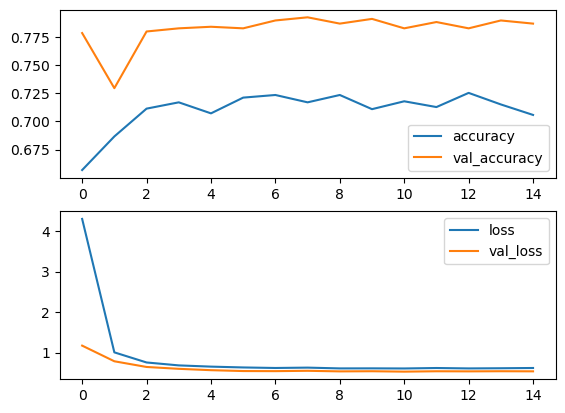

In [36]:
plot_history(history)

In [37]:
results = model.evaluate(test_dataset)
print("test loss, test acc:", results)

23/23 ━━━━━━━━━━━━━━━━━━━━ 4s 180ms/step - accuracy: 0.7972 - loss: 0.5172
test loss, test acc: [0.521201491355896, 0.7841225862503052]


In [48]:
true, pred = predict(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
[[0.91519064]
 [0.8931056 ]
 [0.3479077 ]
 [0.6179851 ]
 [0.80939585]
 [0.8488695 ]
 [0.863111  ]
 [0.60033065]
 [0.51353204]
 [0.5494805 ]
 [0.91017276]
 [0.2982004 ]
 [0.7536171 ]
 [0.70242774]
 [0.8062818 ]
 [0.694845  ]
 [0.4704508 ]
 [0.7197991 ]
 [0.65399855]
 [0.7761295 ]
 [0.6312458 ]
 [0.6969131 ]]
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
[[0.9130355 ]
 [0.5687252 ]
 [0.74322563]
 [0.5416903 ]
 [0.7064393 ]
 [0.89934045]
 [0.7037566 ]
 [0.3991235 ]
 [0.330029  ]
 [0.28199366]
 [0.744142  ]
 [0.8930074 ]
 [0.7939484 ]
 [0.85831994]
 [0.8774168 ]
 [0.42745635]
 [0.71726155]
 [0.84813327]
 [0.47321627]
 [0.8200884 ]
 [0.8626668 ]
 [0.8900712 ]]
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
[[

In [50]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.68      0.41      0.51       198
           1       0.81      0.93      0.86       520

    accuracy                           0.78       718
   macro avg       0.74      0.67      0.69       718
weighted avg       0.77      0.78      0.77       718



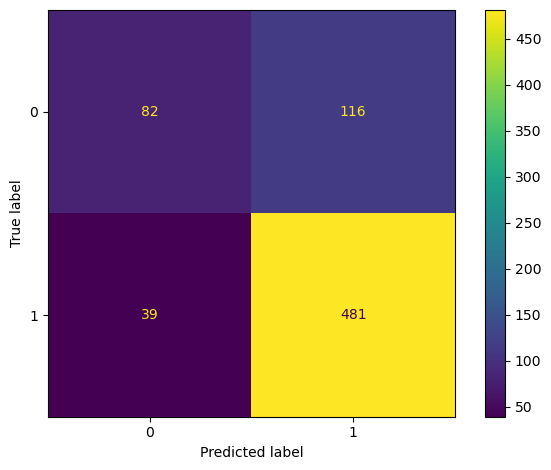

In [51]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

## Top 4 layers

In [52]:
# unfreeze top 4 base layers
for layer in base_model.layers[-4:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 8, 8, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │      1,025 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 27,159,085 (103.60 MB)

 Trainable params: 5,262,849 (20.08 MB)

 Non-trainable params: 17,697,832 (67.51 MB)

 Optimizer params: 4,198,404 (16.02 MB)

In [53]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=5)

In [54]:
# top 4 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=20
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 206ms/step - accuracy: 0.7506 - loss: 0.6034 - val_accuracy: 0.7741 - val_loss: 0.5551
Epoch 2/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.7485 - loss: 0.5842 - val_accuracy: 0.7406 - val_loss: 0.5700
Epoch 3/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 87ms/step - accuracy: 0.7360 - loss: 0.5771 - val_accuracy: 0.7378 - val_loss: 0.5738
Epoch 4/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.7592 - loss: 0.5702 - val_accuracy: 0.7406 - val_loss: 0.5741
Epoch 5/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.7540 - loss: 0.5617 - val_accuracy: 0.7476 - val_loss: 0.5713
Epoch 6/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.7572 - loss: 0.5516 - val_accuracy: 0.7545 - val_loss: 0.5651
Epoch 7/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.7654 - loss: 0.5503 - val_accuracy: 0.7573 - val_loss: 0.5624
Epoch 8/20
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.7700 - loss: 0.5431 - val_accuracy: 0

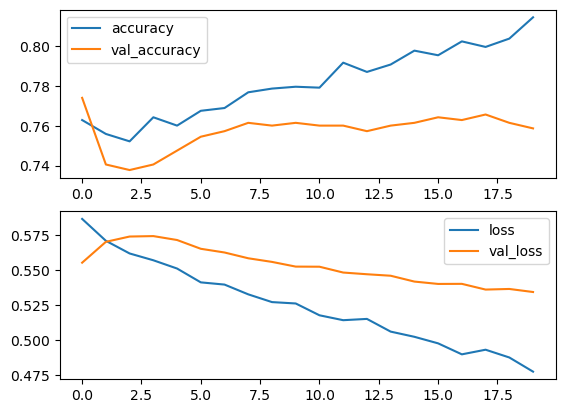

In [55]:
plot_history(history)

In [56]:
true, pred = predict(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2024-09-07 18:24:32.878629: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [57]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.57      0.69      0.62       198
           1       0.87      0.80      0.83       520

    accuracy                           0.77       718
   macro avg       0.72      0.75      0.73       718
weighted avg       0.79      0.77      0.78       718



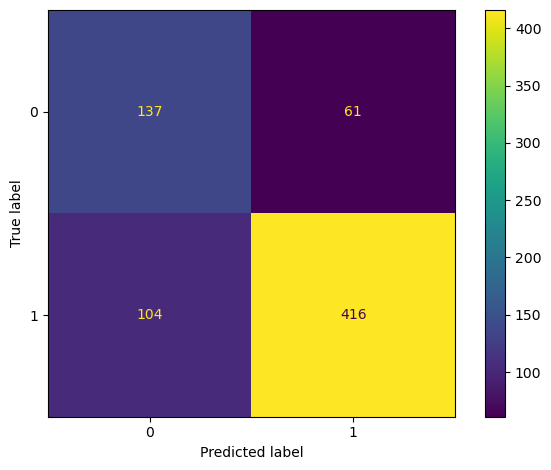

In [58]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

In [59]:
model.save("4-layers-big-binary.keras")

## Top 8 layers

In [60]:
# unfreeze top 8 base layers
for layer in base_model.layers[-8:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 8, 8, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │      1,025 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 33,486,381 (127.74 MB)

 Trainable params: 6,850,049 (26.13 MB)

 Non-trainable params: 16,110,632 (61.46 MB)

 Optimizer params: 10,525,700 (40.15 MB)

In [61]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=10)

In [62]:
# top 8 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=40
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 215ms/step - accuracy: 0.7812 - loss: 0.5609 - val_accuracy: 0.7978 - val_loss: 0.4930
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 8s 86ms/step - accuracy: 0.7943 - loss: 0.5249 - val_accuracy: 0.8047 - val_loss: 0.4875
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - accuracy: 0.8041 - loss: 0.5039 - val_accuracy: 0.7922 - val_loss: 0.4877
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - accuracy: 0.8157 - loss: 0.4844 - val_accuracy: 0.7824 - val_loss: 0.4932
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 6s 88ms/step - accuracy: 0.8179 - loss: 0.4736 - val_accuracy: 0.7852 - val_loss: 0.4937
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 87ms/step - accuracy: 0.8329 - loss: 0.4552 - val_accuracy: 0.7810 - val_loss: 0.4961
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 11s 106ms/step - accuracy: 0.8419 - loss: 0.4431 - val_accuracy: 0.7866 - val_loss: 0.4938
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.8433 - loss: 0.4318 - val_accuracy: 0.

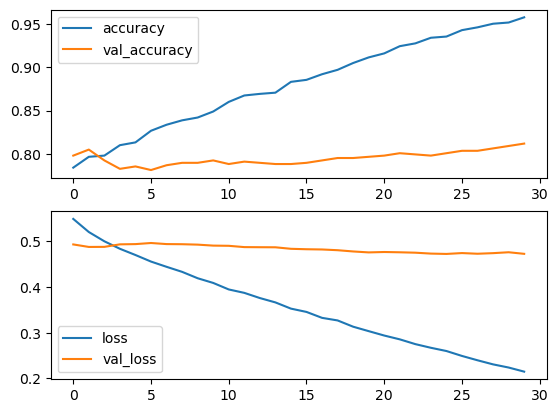

In [63]:
plot_history(history)

In [64]:
true, pred = predict(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [65]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       198
           1       0.89      0.86      0.87       520

    accuracy                           0.82       718
   macro avg       0.78      0.79      0.78       718
weighted avg       0.83      0.82      0.82       718



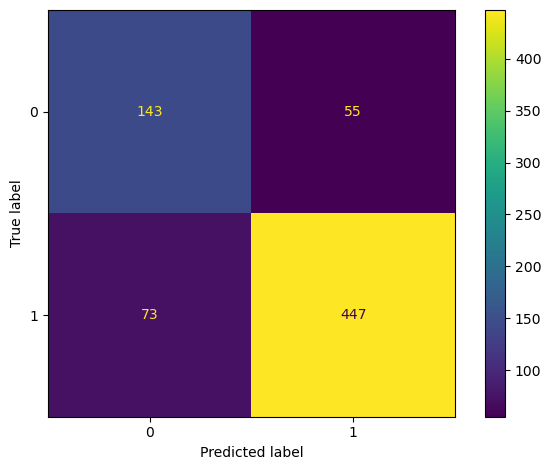

In [66]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

In [67]:
model.save("8-layers-big-binary.keras")

## Top 10 layers

In [68]:
for layer in base_model.layers[-10:]:
    layer.trainable = True
model.summary(show_trainable=True)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)                ┃ Output Shape          ┃    Param # ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_2 (InputLayer)  │ (None, 256, 256, 3)   │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ xception (Functional)       │ (None, 8, 8, 2048)    │ 20,861,480 │   N   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ global_average_pooling2d_1  │ (None, 2048)          │          0 │   -   │
│ (GlobalAveragePooling2D)    │                       │            │       │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_2 (Dense)             │ (None, 1024)          │  2,098,176 │   Y   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dropout_1 (Dropout)         │ (None, 1024)          │          0 │   -   │
├─────────────────────────────┼───────────────────────┼────────────┼───────┤
│ dense_3 (Dense)             │ (None, 1)             │      1,025 │   Y   │
└─────────────────────────────┴───────────────────────┴────────────┴───────┘

 Total params: 36,660,781 (139.85 MB)

 Trainable params: 7,595,521 (28.97 MB)

 Non-trainable params: 15,365,160 (58.61 MB)

 Optimizer params: 13,700,100 (52.26 MB)

In [69]:
callback = EarlyStopping(patience=5, restore_best_weights=True, monitor="val_loss", start_from_epoch=15)

In [70]:
# top 10 layers unfrozen
model.compile(optimizer=keras.optimizers.Adam(5e-6),
              loss='binary_crossentropy',
              metrics=['accuracy'])

epochs=60
history = model.fit(train_dataset, epochs=epochs, validation_data=val_dataset, callbacks=callback)

Epoch 1/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 22s 195ms/step - accuracy: 0.9465 - loss: 0.2457 - val_accuracy: 0.7964 - val_loss: 0.4978
Epoch 2/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 89ms/step - accuracy: 0.9525 - loss: 0.2323 - val_accuracy: 0.8006 - val_loss: 0.4885
Epoch 3/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 106ms/step - accuracy: 0.9567 - loss: 0.2275 - val_accuracy: 0.8006 - val_loss: 0.4941
Epoch 4/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.9567 - loss: 0.2196 - val_accuracy: 0.8006 - val_loss: 0.4822
Epoch 5/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9648 - loss: 0.2128 - val_accuracy: 0.8020 - val_loss: 0.4854
Epoch 6/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 7s 107ms/step - accuracy: 0.9640 - loss: 0.2048 - val_accuracy: 0.8020 - val_loss: 0.4836
Epoch 7/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - accuracy: 0.9680 - loss: 0.2036 - val_accuracy: 0.8006 - val_loss: 0.4825
Epoch 8/60
68/68 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.9689 - loss: 0.2000 - val_accuracy: 0.8

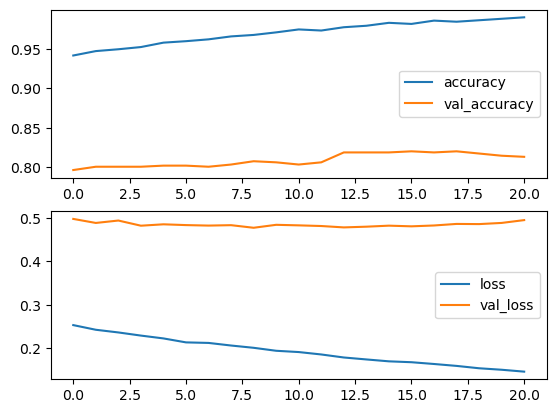

In [71]:
plot_history(history)

In [72]:
true, pred = predict(test_dataset, model)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [73]:
print(classification_report(true, pred))

              precision    recall  f1-score   support

           0       0.67      0.70      0.69       198
           1       0.88      0.87      0.88       520

    accuracy                           0.82       718
   macro avg       0.78      0.79      0.78       718
weighted avg       0.83      0.82      0.82       718



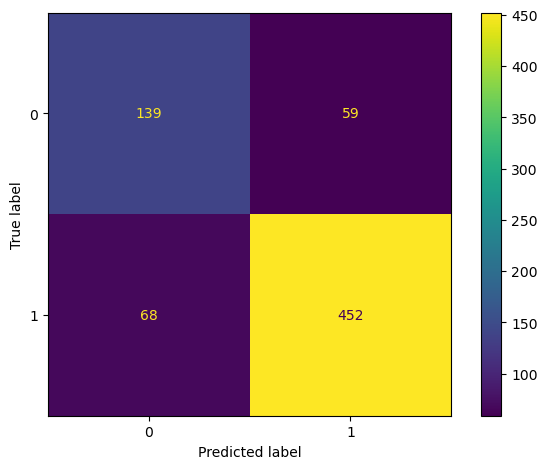

In [74]:
cm = confusion_matrix(true, pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.tight_layout()

In [75]:
model.save("10-layers-big-binary.keras")

Both models perform similarly in a binary context (i.e., combining the 0s and 1s into a single class)

## ROC and Precision-Recall curves

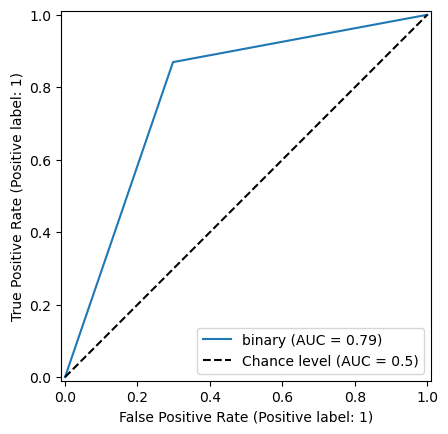

In [93]:
disp = RocCurveDisplay.from_predictions(true, pred, name="binary", plot_chance_level=True)
# plt.plot([0, 1], [0, 1], color='k', linestyle='--')

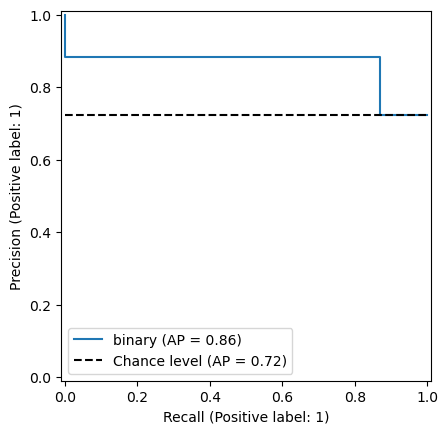

In [91]:
disp = PrecisionRecallDisplay.from_predictions(true, pred, name="binary", plot_chance_level=True)